## Day 25 Lecture 1 Assignment

In this assignment, we will evaluate the performance of the model we built yesterday on the Chicago traffic crash data. We will also perform hyperparameter tuning and evaluate a final model using additional metrics (e.g. AUC-ROC, precision, recall, etc.)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import cross_val_score, cross_val_predict

%matplotlib inline

Since we will be building on the model we built in the last assignment, we will need to redo all of the data preparation steps up to the point of model building. These steps include creating the response, missing value imputation, and one-hot encoding our selected categorical variables. The quickest way to get going would be to open last week's assignment, make a copy, and build on it from there.

In [2]:
def missingness_summary(df, print_log=False, sort='none'):
    summary = df.apply(lambda x: x.isna().sum() / x.shape[0])
    
    if print_log == True:
      if sort == 'none':
          print(summary)
      elif sort == 'ascending':
          print(summary.sort_values())
      elif sort == 'descending':
          print(summary.sort_values(ascending=False))
      else:
          print('Invalid value for sort parameter.')
        
    return summary

In [3]:
crash_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/traffic_crashes_chicago.csv')
crash_data_copy = crash_data.copy()

crash_data['HIGH_DAMAGE'] = (crash_data['DAMAGE'] == 'OVER $1,500').astype(int)

missing_report = missingness_summary(crash_data, print_log=False, sort='none')
missing_data_columns = missing_report.loc[missing_report > 0.05].index
crash_data.drop(columns=missing_data_columns, inplace=True)

crash_num_df = crash_data.select_dtypes(include='number')
crash_cat_df = crash_data.select_dtypes(include='O')

for col in crash_num_df.columns:
  crash_data[col] = crash_data[col].fillna(crash_data[col].median())

crash_data.dropna(inplace=True)

missing_report = missingness_summary(crash_data, print_log=True, sort='none')

RD_NO                            0.0
CRASH_DATE                       0.0
POSTED_SPEED_LIMIT               0.0
TRAFFIC_CONTROL_DEVICE           0.0
DEVICE_CONDITION                 0.0
WEATHER_CONDITION                0.0
LIGHTING_CONDITION               0.0
FIRST_CRASH_TYPE                 0.0
TRAFFICWAY_TYPE                  0.0
ALIGNMENT                        0.0
ROADWAY_SURFACE_COND             0.0
ROAD_DEFECT                      0.0
REPORT_TYPE                      0.0
CRASH_TYPE                       0.0
DAMAGE                           0.0
DATE_POLICE_NOTIFIED             0.0
PRIM_CONTRIBUTORY_CAUSE          0.0
SEC_CONTRIBUTORY_CAUSE           0.0
STREET_NO                        0.0
STREET_DIRECTION                 0.0
STREET_NAME                      0.0
BEAT_OF_OCCURRENCE               0.0
NUM_UNITS                        0.0
MOST_SEVERE_INJURY               0.0
INJURIES_TOTAL                   0.0
INJURIES_FATAL                   0.0
INJURIES_INCAPACITATING          0.0
I

In [4]:
crash_features = crash_data.filter(['POSTED_SPEED_LIMIT', 'INJURIES_TOTAL'])
weather_df = pd.get_dummies(crash_data['WEATHER_CONDITION'], drop_first=True)
crash_features = pd.concat([crash_features, weather_df], axis=1)

crashtype_df = pd.get_dummies(crash_data['FIRST_CRASH_TYPE'], drop_first=True)
crash_features = pd.concat([crash_features, crashtype_df], axis=1)

Statsmodels' implementation of logistic has certain advantages over scikit-learn's, such as clean, easy to read model summary output and statistical inference values (e.g. p-values). However, scikit-learn is preferable for model evaluation, so we will switch to the scikit-learn implementation for this exercise. 

Run logistic regression on the training set and use the resulting model to make predictions on the test set. Calculate the train and test error using logarithmic loss. How do they compare to each other?

In [5]:
X = crash_features
y = crash_data['HIGH_DAMAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
logit = LogisticRegression(max_iter=1000)

logit.fit(X_train, y_train)

test_score = logit.score(X_test, y_test)
train_score = logit.score(X_train, y_train)

print(f'Testing accuracy is: {test_score:.3f}')
print(f'Training accuracy is: {train_score:.3f}')

Testing accuracy is: 0.585
Training accuracy is: 0.583


Next, evaluate the performance of the same model using 10-fold CV. Use the training data and labels, and print out the mean log loss for each of the 10 CV folds, as well as the overall CV-estimated test error. How do the estimates from the individual folds compare to the result from our previous single holdout set? How much variability in the estimated test error do you see across the 10 folds?

Note: scikit-learn's *cross_val_score* function provides a simple, one-line method for doing this. However, be careful - the default score returned by this function may not be log loss!

In [7]:
# answer goes here (changed to cv=5, since 10 was too long to process)
logit = LogisticRegression(max_iter=1000)
cv_logloss = cross_val_score(logit, X_train, y_train, cv=5, scoring='neg_log_loss')
cv = cross_val_score(logit, X_train, y_train, cv=5)

In [8]:
print(f'Avg Log Loss: {cv_logloss.mean():.4f}, STD: {cv_logloss.std():.4f},\n Log Losses = {cv_logloss}')

print(f'Mean: {cv.mean():.4f}, STD: {cv.std():.4f},\n cv = {cv}')

Avg Log Loss: -0.6584, STD: 0.0009,
 Log Losses = [-0.65886246 -0.65887371 -0.65810177 -0.65917899 -0.65682283]
Mean: 0.5831, STD: 0.0018,
 cv = [0.58415022 0.58400309 0.58462076 0.57969175 0.58324137]


Scikit-learn's logistic regression function has a built-in regularization parameter, C (the larger the value of C, the smaller the degree of regularization). Use a loop with values of C, and find the optimum C value by taking the highest average cross validation score.

In [9]:
# answer goes here
c_vals = np.arange(0.1, 1.5, 0.1)
test_accuracy = []
train_accuracy = []

for c in c_vals:
  logit = LogisticRegression(max_iter=1000, C=c)
  logit.fit(X_train, y_train)
  test_accuracy.append(logit.score(X_test, y_test))
  train_accuracy.append(logit.score(X_train, y_train))

In [10]:
train_test_diff = np.array(test_accuracy) - np.array(train_accuracy)
c_val_df = pd.DataFrame({'C_values': c_vals, 
                         'Test_Acc': test_accuracy, 
                         'Train_Acc': train_accuracy,
                         'Test_Train_diff': train_test_diff})

c_val_df.head()

,C_values,Test_Acc,Train_Acc,Test_Train_diff
0,0.1,0.584710,0.583285,0.001425
1,0.2,0.584743,0.583281,0.001462
2,0.3,0.584721,0.583244,0.001477
3,0.4,0.584765,0.583285,0.001480
4,0.5,0.584765,0.583285,0.001480


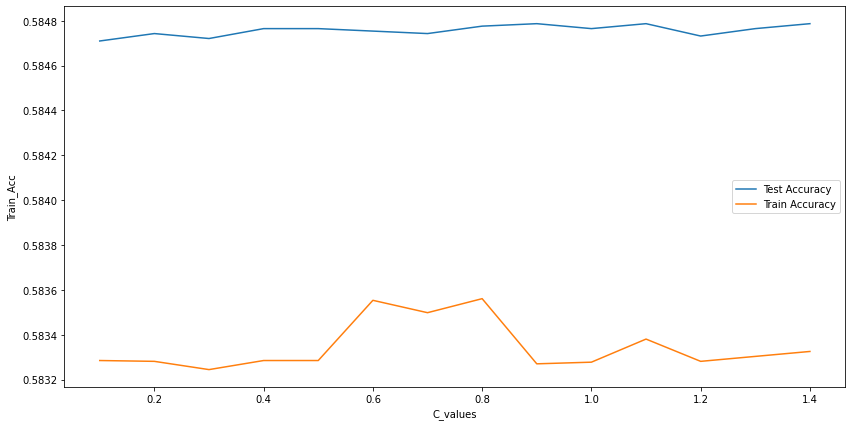

In [11]:
plt.figure(figsize=(14,7))
sns.lineplot(y = c_val_df['Test_Acc'], x= c_val_df['C_values'], label='Test Accuracy')
sns.lineplot(y = c_val_df['Train_Acc'], x= c_val_df['C_values'], label='Train Accuracy')
plt.show()

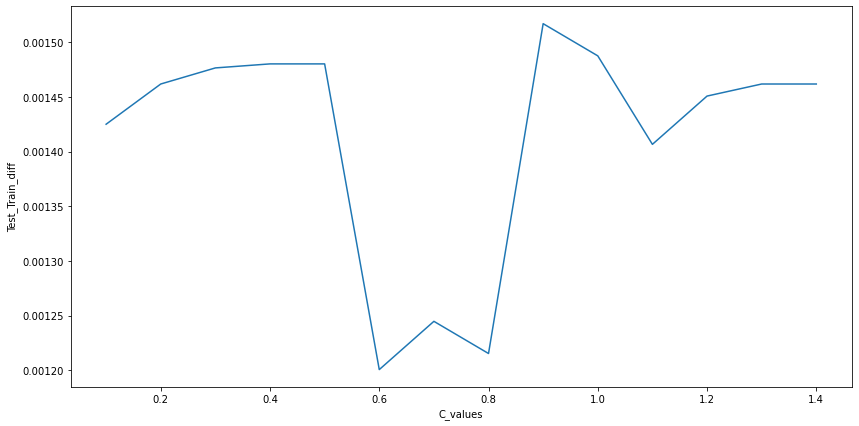

In [12]:
plt.figure(figsize=(14,7))
sns.lineplot(y = c_val_df['Test_Train_diff'], x= c_val_df['C_values'])
plt.show()

In [13]:
c_val_df['C_values'].loc[c_val_df['Test_Train_diff'] == c_val_df['Test_Train_diff'].min()]

5    0.6
Name: C_values, dtype: float64

Re-train a logistic regression model using the best value of C identified by 10-fold CV on the training data and labels. Afterwards, do the following:

- Determine the precision, recall, and F1-score of our model using a cutoff/threshold of 0.5 (hint: scikit-learn's *classification_report* function may be helpful)
- Plot or otherwise generate a confusion matrix
- Plot the ROC curve for our logistic regression model

Note: the performance of our simple logistic regression model with just four features will not be very good, but this is not entirely unexpected. There are many other features that can be incorporated into the model to improve its performance; feel free to experiment!

In [14]:
# answer goes here
c=0.7
logit = LogisticRegression(max_iter=1000, C=c)
cv = cross_val_score(logit, X_train, y_train, cv=5)
#y_pred = cross_val_predict(logit, X_train, y_train, cv=5)

print(f'Mean: {cv.mean():.4f}, STD: {cv.std():.4f},\n cv = {cv}')

Mean: 0.5831, STD: 0.0018,
 cv = [0.58411344 0.58402148 0.58484146 0.57969175 0.58289193]


In [15]:
logit = LogisticRegression(max_iter=1000, C=c)
logit.fit(X_train, y_train)

test_score = logit.score(X_test, y_test)
train_score = logit.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.5832849018987575
Score on test data:  0.5847540856975756


In [16]:
predictions = logit.predict(X_test)
report = classification_report(y_test, predictions, labels= [0,1], target_names=['Low Damage', 'High Damage'])
print(report)

              precision    recall  f1-score   support

  Low Damage       0.55      0.30      0.39     39762
 High Damage       0.60      0.81      0.69     50859

    accuracy                           0.58     90621
   macro avg       0.57      0.55      0.54     90621
weighted avg       0.58      0.58      0.55     90621



In [22]:
conf_mat = confusion_matrix(y_test, predictions, labels= [0,1])
conf_mat

array([[11870, 27892],
       [ 9738, 41121]])

In [18]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

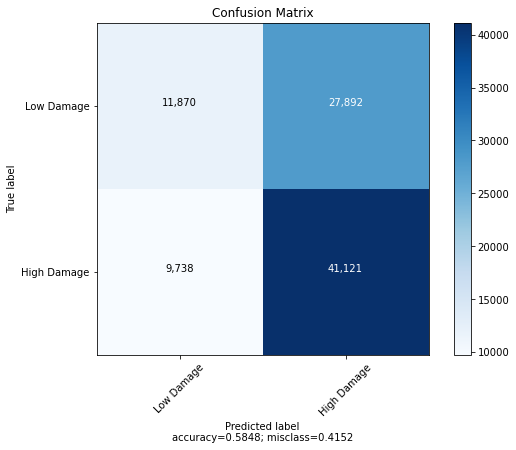

In [26]:
plot_confusion_matrix(cm=conf_mat, target_names = ['Low Damage', 'High Damage'], title = 'Confusion Matrix', normalize=False)

In [25]:
probs = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probs)

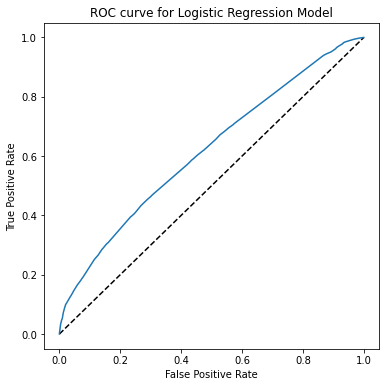

In [21]:
fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression Model')
plt.show()